In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import chisquare, kstest, norm, combine_pvalues
from IPython.display import display, Markdown

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Non-spatial Dispersal Coverage Test

In [3]:
def test_nonspatial_dispersal_coverage(
    algorithm, speciation=0.001, seeds=[42], size=100, sample=1.0
):
    total_pvalues = []
    total_locations = []
    
    for seed in seeds:
        # Configure the simulation
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: NonSpatial(
                area: ({size}, {size}),
                deme: {size},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalCoverage(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, size=size,
        ).split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        locations_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the dispersal locations
        locations = []
        with locations_io:
            reader = csv.reader(locations_io)
            next(reader)

            for row in reader:
                locations.append((int(row[3]), int(row[4]), int(row[5])))
        locations = np.array(locations)

        # Calculate the goodness of fit of the dispersal coverage
        gof = chisquare(np.histogramdd(locations, bins=(
            range(0, size+1), range(0, size+1), range(0, size+1)
        ))[0].flatten())
        
        total_pvalues.append(gof.pvalue)
        total_locations.append(locations)
    
    gof_statistic, gof_pvalue = combine_pvalues(total_pvalues)
    
    if gof_pvalue <= 0.01 or gof_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.05 or gof_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.1 or gof_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Fisher’s combined Chi-squared test:"))
    display(Markdown(f"* p-value: {gof_pvalue}\n* statistic: {gof_statistic}"))
    
    display(Markdown("#### Dispersal Histograms:"))
    
    locations = np.concatenate(total_locations)
    
    # Draw the 1d and 2d dispersal coverage histograms
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 10))
    
    ax1.set_title("Dispersal histogram x")
    ax1.set_xlabel("x")
    ax1.set_ylabel("pmf")
    ax1.hist(locations[:,0], bins=range(0, size+1), density=True)
    
    ax2.set_title("Dispersal histogram y")
    ax2.set_xlabel("y")
    ax2.set_ylabel("pmf")
    ax2.hist(locations[:,1], bins=range(0, size+1), density=True)
    
    ax3.set_title("Dispersal histogram index")
    ax3.set_xlabel("index")
    ax3.set_ylabel("pmf")
    ax3.hist(locations[:,2], bins=range(0, size+1), density=True)

    ax4.set_title("Dispersal histogram x-y")
    ax4.set_xlabel("x")
    ax4.set_ylabel("y")
    hist1 = ax4.hist2d(locations[:,0], locations[:,1],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist1[3], ax=ax4)

    ax5.set_title("Dispersal histogram x-index")
    ax5.set_xlabel("x")
    ax5.set_ylabel("index")
    hist2 = ax5.hist2d(locations[:,0], locations[:,2],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist2[3], ax=ax5)

    ax6.set_title("Dispersal histogram y-index")
    ax6.set_xlabel("y")
    ax6.set_ylabel("index")
    hist3 = ax6.hist2d(locations[:,1], locations[:,2],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist3[3], ax=ax6)

    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.4559885007544749
* statistic: 20.031056314358704

#### Dispersal Histograms:

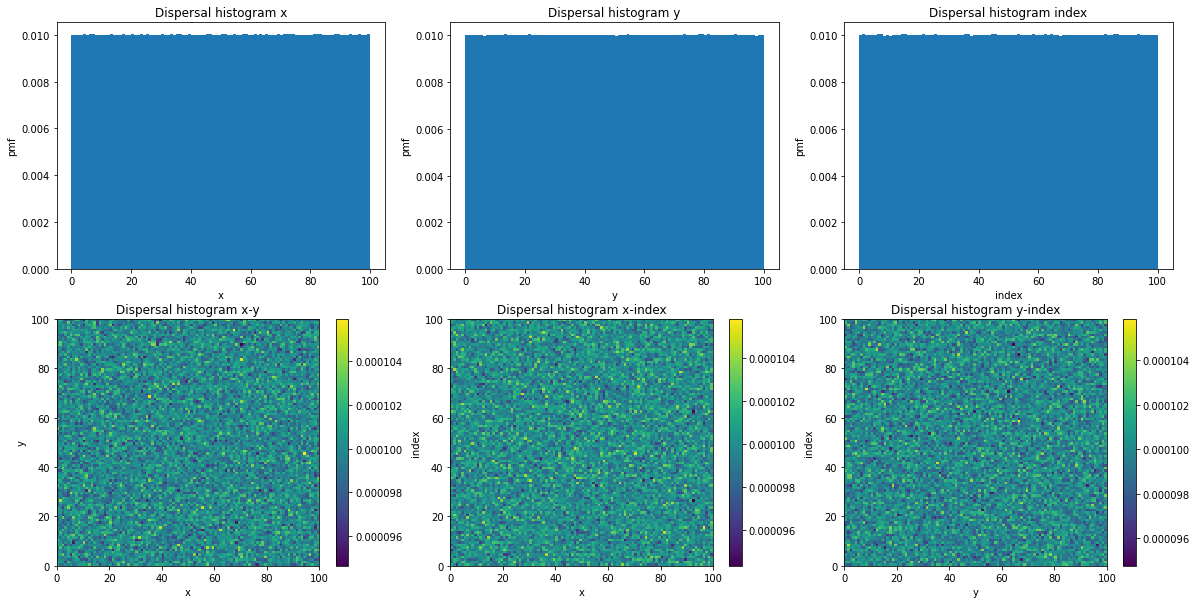

#### Parameters:
* seeds: [ 9575775898272840943  9235873870639362056 13241147643469470344
 17416352869997883216 15759549624767601113 14710167364370210098
 15664748068737114616 13842244256485791350  3043071697143158119
 12083889669828003836]

#### Configuration:
```rust
(speciation:1e-06,seed:12083889669828003836,sample:0.0001,algorithm:Classical(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>Gillespie</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.5127575882253388
* statistic: 19.139779687068767

#### Dispersal Histograms:

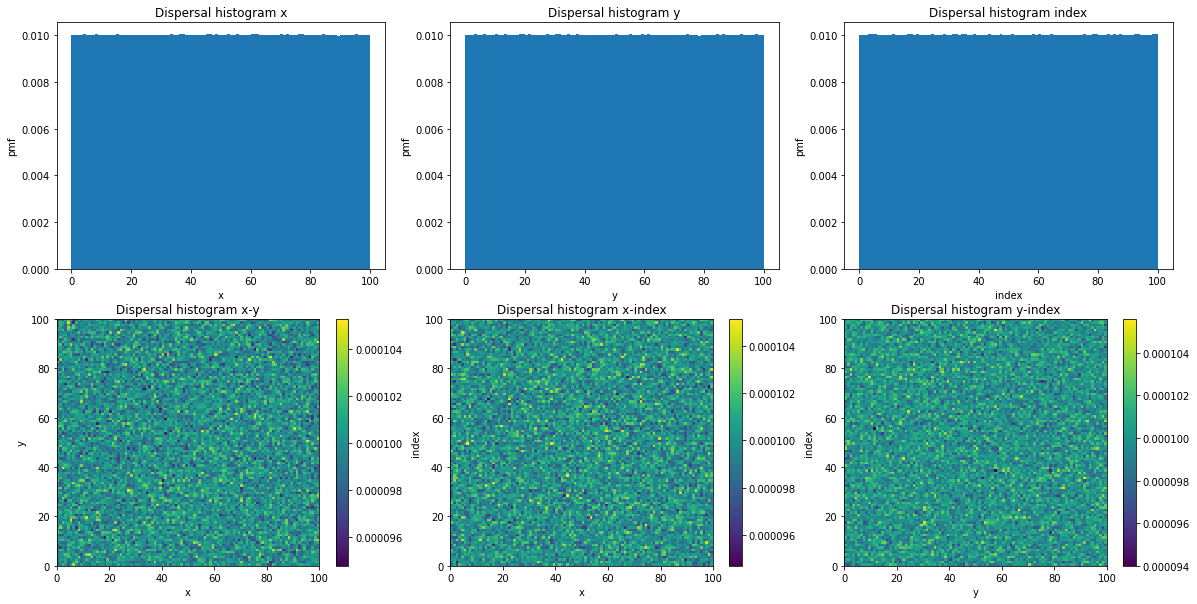

#### Parameters:
* seeds: [16266131475822773234 10790639553165602876  1621516794709484739
  7736893656532021853 14294332776259745755  7886683680339319956
 10747967203647938162 11324027708315176560  1327325965904417440
  7351242209209387129]

#### Configuration:
```rust
(speciation:1e-06,seed:7351242209209387129,sample:0.0001,algorithm:Gillespie(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.7298061672272668
* statistic: 15.786038936424418

#### Dispersal Histograms:

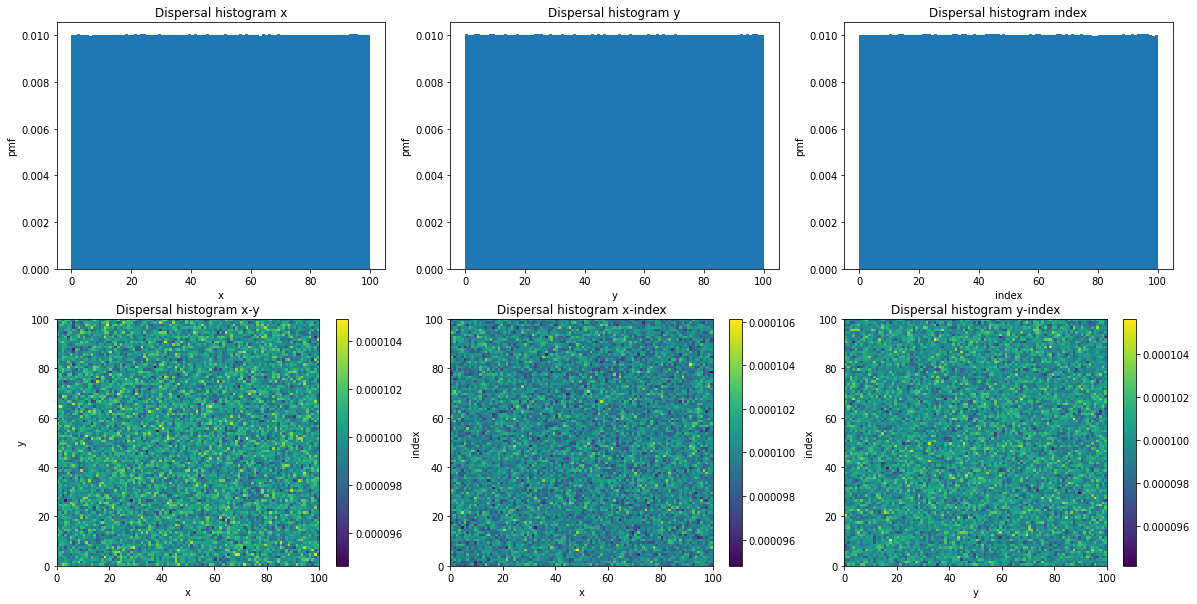

#### Parameters:
* seeds: [14182547828100744353  8442444015708509397  8927912135394700948
 10197779191948695394 12539794470852755597  1107656303722143180
 18136839974584156288  4711819247590662308  2289350771127586566
 13901934896954265219]

#### Configuration:
```rust
(speciation:1e-06,seed:13901934896954265219,sample:0.0001,algorithm:SkippingGillespie(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>Independent</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.3585985776407458
* statistic: 21.671501303424186

#### Dispersal Histograms:

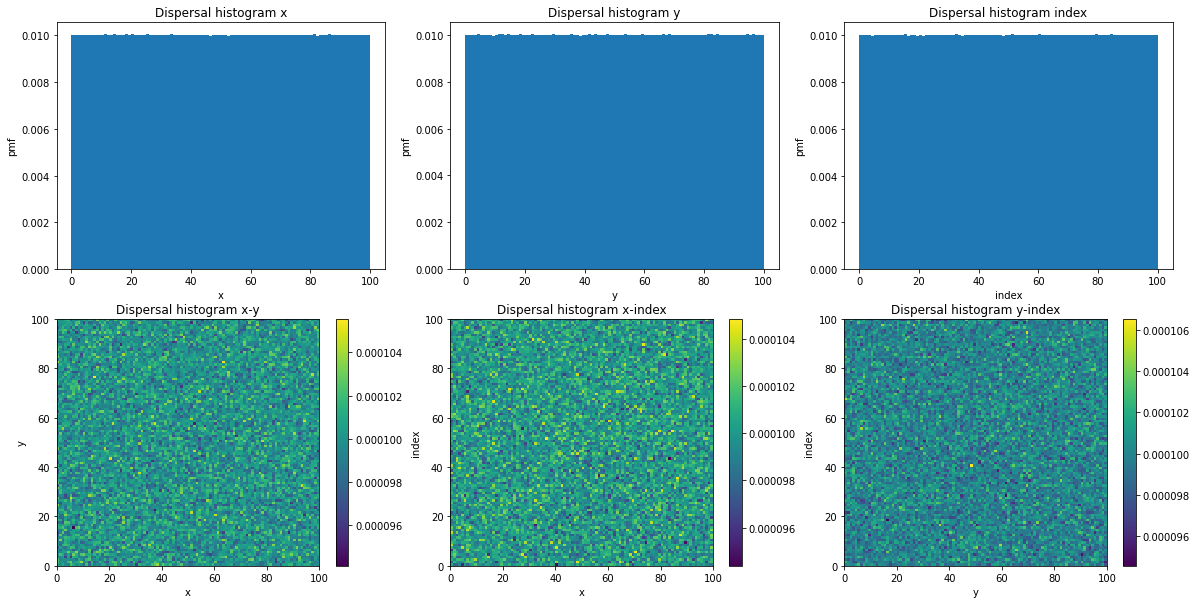

#### Parameters:
* seeds: [ 2892310192831992488 13539400425179626643  7050820561175953511
  4271261927186219277 16749136487933606152  9224605037980822605
 15622635219194964102  4364181242182762816 15687627610531192363
  9564540989248073860]

#### Configuration:
```rust
(speciation:1e-06,seed:9564540989248073860,sample:0.0001,algorithm:Independent(),scenario:NonSpatial(area:(100,100),deme:100),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=10)
    
    test_nonspatial_dispersal_coverage(
        algorithm, size=100, seeds=seeds, sample=0.0001, speciation=0.000001
    )